# Deep Neural Network for MultiClass Classification

## Stage 1: We load the data and required libraries.

For this example, we use the dataset MNIST, which configures a problem of multiclass clasification (10 classes). The idea is to predict a number (0-9) form 28x28 images.

In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# MNIST dataset is available in pytorch

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
# Showing some examples
img, label = training_data[0]
print(img.shape, label)

torch.Size([1, 28, 28]) 5


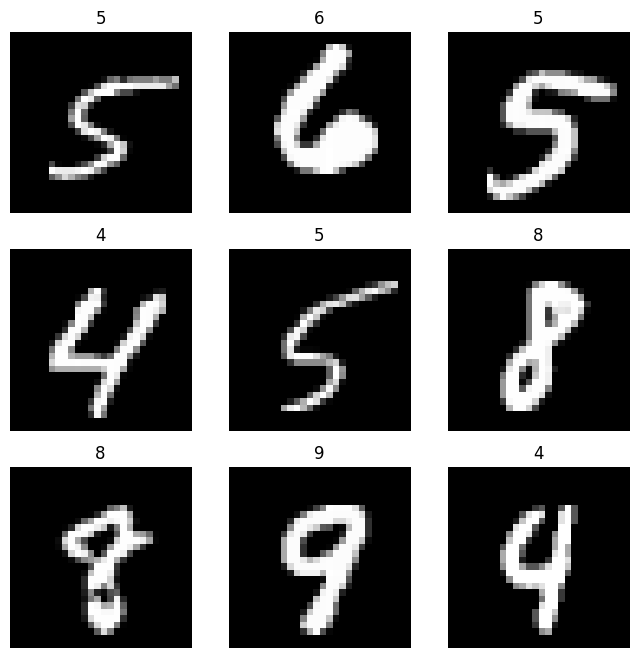

In [4]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# We define an object to load the data
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Stage 2: Deep Neural Network definiton.

In [ ]:
# We do this to use the GPU (if we only use CPU, the training will take a lot of time)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            # images 28x28x1
            nn.Conv2d(1, 32, 3, 1, 0),  # Of = (Nf - f)/s + 1 = (28 - 3)/1 + 1
            # 26x26x32
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Of = (Nf - f)/s + 1 = (26 - 2)/2 + 1
            # 13x13x32 #(filas - tamañoFiltro)/stride + 1

            ## flatten()
            nn.Flatten(),
            # Vector (ya es compatible con fully-connected)


            # Capas fully-connected
            nn.Linear(13*13*32, 32), # The previous layer has 13*13*32 units.
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10), # Note that the output layer has 10 units, Also
            # notice that we don't use any activation. This is because the loss
            # function computes the Softmax function internally.
        )

    def forward(self, x):
        # This method is used to compute the output given a particular input x.
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
# WE can verify the built network
model = NeuralNetwork()
model.to(device) # This is to define the model in the GPU
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=5408, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [ ]:
# WE define the hyperparameters and the loss function
learning_rate = 0.05
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# The optimization loop.

loss_tr = []
loss_te = []
for epoch in range(epochs):
  for x, y in train_dataloader:
    # The variable should be sent to the GPU
    x = x.to(device)
    y = y.to(device)
    # Make predictions
    model.train()
    y_pred = model(x)
    # Compute the loss of current predictions
    loss = loss_fn(y_pred, y)
    # Clean the gradients
    optimizer.zero_grad()
    # Perform backpropagation
    loss.backward()
    # update weights
    optimizer.step()
    # Storing the training and test losses
    loss_tr.append(loss.item())
    loss_test = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        loss_test += loss_fn(outputs, labels).item() * labels.size(0)

  loss_te.append(loss_test/len(test_dataloader.dataset))
  print("epoch {} loss: {:.4f} test_loss: {:.4f}".format(epoch + 1,loss.item(),loss_test/len(test_dataloader.dataset)))

epoch 1 loss: 0.1568 test_loss: 0.2539
epoch 2 loss: 0.1474 test_loss: 0.1522
epoch 3 loss: 0.0167 test_loss: 0.1004
epoch 4 loss: 0.1104 test_loss: 0.0841
epoch 5 loss: 0.1221 test_loss: 0.0815
epoch 6 loss: 0.0144 test_loss: 0.0564
epoch 7 loss: 0.0663 test_loss: 0.0559
epoch 8 loss: 0.0155 test_loss: 0.0508
epoch 9 loss: 0.0050 test_loss: 0.0527
epoch 10 loss: 0.1483 test_loss: 0.0699
epoch 11 loss: 0.0102 test_loss: 0.0482
epoch 12 loss: 0.0043 test_loss: 0.0454
epoch 13 loss: 0.0062 test_loss: 0.0497
epoch 14 loss: 0.0010 test_loss: 0.0436
epoch 15 loss: 0.1743 test_loss: 0.0572
epoch 16 loss: 0.0006 test_loss: 0.0467
epoch 17 loss: 0.0005 test_loss: 0.0478
epoch 18 loss: 0.0088 test_loss: 0.0479
epoch 19 loss: 0.0385 test_loss: 0.0531
epoch 20 loss: 0.0023 test_loss: 0.0476


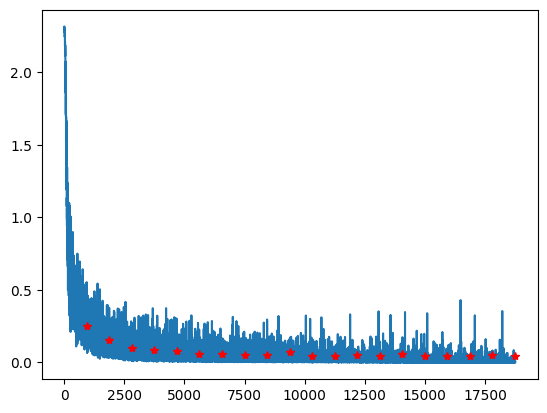

In [ ]:
# Plot the losses for the train and test sets
import numpy as np
plt.plot(loss_tr)
plt.plot(np.arange(1,21)*len(train_dataloader.dataset)//64,loss_te, 'r*')
plt.show()

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 98 %
